In [1]:
import pandas as pd
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

seed = 7

data = pd.read_csv('data/sepsis_final.csv').drop(['Unnamed: 0', 'SUBJECT_ID', 'HADM_ID'], axis=1)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)

X = data.drop(['28 Day Death', 'In Hospital Death'], axis=1)
y = data['28 Day Death']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)

In [2]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(n_estimators=220, max_depth=7, random_state=seed).fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.8664195807997971
Average Precision: 0.8229857460690426
Accuracy: 0.789319678127286


In [4]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/home/llja/repos/Uni_ACS/medical_explainer.py'>

In [5]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)
# explainer.plot_calibration_original()
# explainer.calibrate()
# explainer.plot_calibration_calibrated()


| Step 1  ==> Calibrating model


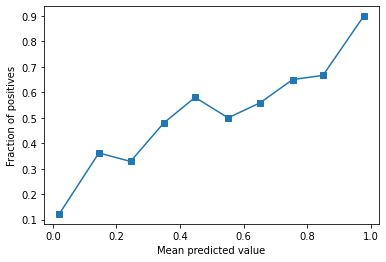

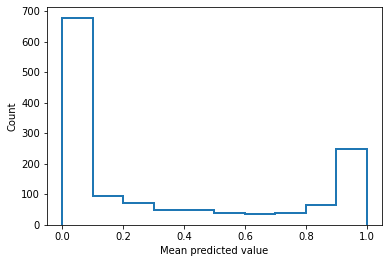

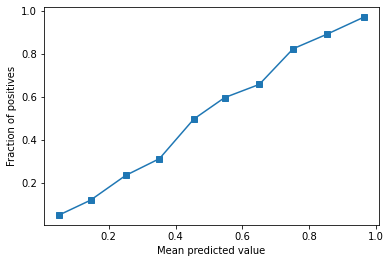

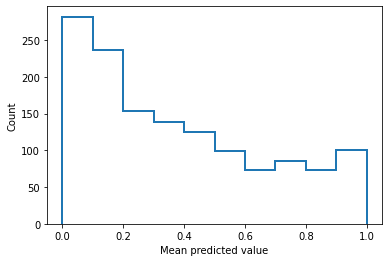

ROC AUC: 0.8664195807997971
Average Precision: 0.8229857460690426
Accuracy: 0.789319678127286
ROC AUC: 0.8721534530098864
Average Precision: 0.8290653997048896
Accuracy: 0.7995610826627652

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 26.0

Probability threshold: 0.5
Score threshold: 42.0

Probability threshold: 0.9
Score threshold: 58.0



In [6]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel')

In [11]:
explainer.variables

array(['LOS', 'RDW', 'ICU_LOS', 'Age', 'inotropes',
       'Lactate Dehydrogenase (LD)', 'ICUs', 'Albumin', 'Phosphate',
       'Haptoglobin'], dtype=object)

In [7]:
explainer.score_array_list

[array([11., -7.]),
 array([-4.,  5.]),
 array([-3.,  5.]),
 array([-3.,  4.]),
 array([-5.,  3.]),
 array([-3.,  1.]),
 array([ 1., -1.,  6.]),
 array([ 2., -1.]),
 array([-2.,  1.]),
 array([ 3., -1.])]

In [8]:
explainer.breakpoints_list

[[-0.3222222222222222, 8.410828101389876, 294.66041666666666],
 [11.6, 15.454288566314101, 30.5],
 [0.008, 5.248719849964527, 153.928],
 [18.258726899383984, 72.88063943601284, 90.0],
 [0.0, 0.9373030375089514, 3.0],
 [-8.271937992540188, 192.4997909660624, 23111.0],
 [0.0, 0.47620857694695967, 1.120348572471703, 5.0],
 [0.0, 2.741774085897918, 18.290282614674197],
 [0.2, 3.4469199152619843, 17.3],
 [-151.44629137482752, 157.25498164980556, 688.0]]

In [9]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))

ROC AUC: 0.7445696990566637
Average Precision: 0.6462152297850027
Accuracy: 0.6986100950987564
[[786  58]
 [354 169]]
